In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sera-venenoso/sample_submission.csv
/kaggle/input/sera-venenoso/train.csv
/kaggle/input/sera-venenoso/test.csv


In [2]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',None)

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


import tensorflow as tf

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import VotingClassifier

from sklearn.metrics import accuracy_score


In [3]:
train_data1=pd.read_csv('../input/sera-venenoso/train.csv')
test_data1=pd.read_csv('../input/sera-venenoso/test.csv')
temp_sub=pd.read_csv('../input/sera-venenoso/sample_submission.csv')
test_data1.head()

,id,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,6545,Knobbed,Scaly,Brown,No Bruises,Spicy,Free,Close,Narrow,Buff,Tapering,?,Silky,Silky,Pink,Pink,Partial,White,One,Evanescent,White,Several,Leaves
1,6495,Knobbed,Smooth,Brown,No Bruises,None,Attached,Close,Broad,Brown,Enlarging,?,Smooth,Smooth,Orange,Orange,Partial,Brown,One,Pendant,Buff,Several,Leaves
2,1634,Flat,Fibrous,White,No Bruises,None,Free,Crowded,Broad,Brown,Tapering,Equal,Smooth,Fibrous,White,White,Partial,White,One,Evanescent,Black,Scattered,Grasses
3,6164,Bell,Smooth,Brown,No Bruises,None,Attached,Close,Broad,Yellow,Enlarging,?,Smooth,Smooth,Orange,Orange,Partial,Orange,One,Pendant,Brown,Clustered,Leaves
4,1858,Convex,Fibrous,Brown,Bruises,None,Free,Close,Broad,Brown,Tapering,Bulbous,Smooth,Smooth,White,White,Partial,White,One,Pendant,Black,Several,Wood


In [4]:
train_data1.shape

(4599, 24)

In [5]:
whole_data_set=pd.concat([train_data1, test_data1],axis=0)
data_prep1=whole_data_set.copy()
# data_prep1=train_data1.copy()

## DATA ANALYSIS

In [6]:
# data_prep1=data_prep1.sort_values(by=['id'],ascending=True)

In [7]:
data_prep1.shape

(6571, 24)

In [8]:
data_prep1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6571 entries, 0 to 1971
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        6571 non-null   int64 
 1   class                     4599 non-null   object
 2   cap-shape                 6571 non-null   object
 3   cap-surface               6571 non-null   object
 4   cap-color                 6571 non-null   object
 5   bruises                   6571 non-null   object
 6   odor                      6571 non-null   object
 7   gill-attachment           6571 non-null   object
 8   gill-spacing              6571 non-null   object
 9   gill-size                 6571 non-null   object
 10  gill-color                6571 non-null   object
 11  stalk-shape               6571 non-null   object
 12  stalk-root                6571 non-null   object
 13  stalk-surface-above-ring  6571 non-null   object
 14  stalk-surface-below-ring

In [9]:
data_prep1.duplicated().sum()

0

In [10]:
data_prep1.isna().sum().sum()

1972

In [11]:
data_prep1_index=data_prep1.iloc[:,0]
data_prep1_index.shape

(6571,)

In [12]:
data_prep2=data_prep1.copy()

In [13]:
for i in data_prep2.columns:
    if i!='id':
        print('{}'.format(data_prep2[i].value_counts()))
        print()

Edible       2965
Poisonous    1634
Name: class, dtype: int64

Convex     2990
Flat       2527
Knobbed     584
Bell        434
Sunken       32
c             4
Name: cap-shape, dtype: int64

Scaly      2579
Fibrous    2012
Smooth     1978
Grooves       2
Name: cap-surface, dtype: int64

Brown       1894
Green       1516
Red         1149
White        921
Yellow       809
Buff         116
Pink         111
Cinnamon      39
Purple        16
Name: cap-color, dtype: int64

No Bruises    3443
Bruises       3128
Name: bruises, dtype: int64

None        3479
Foul        1287
Almond       400
Anise        400
Fishy        363
Spicy        347
Pungent      165
Creosote     109
Musty         21
Name: odor, dtype: int64

Free        6368
Attached     203
Name: gill-attachment, dtype: int64

Close      5307
Crowded    1264
Name: gill-spacing, dtype: int64

Broad     4925
Narrow    1646
Name: gill-size, dtype: int64

Pink         1249
White        1103
Buff         1056
Brown        1003
Gray         

In [14]:
data_prep2.shape

(6571, 24)

In [15]:
def clean_data(df):
    df2=df.copy()
    index_to_drop=[]
    [index_to_drop.append(x) for x in df2[df2['cap-surface']=='Grooves'].index.values.tolist()]
    [index_to_drop.append(x) for x in df2.loc[(df2['cap-shape']=='c') | (df2['cap-shape']=='Sunken')].index.values.tolist()]
    [index_to_drop.append(x) for x in df2.loc[(df2['cap-color']=='Cinnamon') | (df2['cap-shape']=='Purple')].index.values.tolist()]
    [index_to_drop.append(x) for x in df2[df2['odor']=='Musty'].index.values.tolist()]
    [index_to_drop.append(x) for x in df2[df2['stalk-color-above-ring']=='Yellow'].index.values.tolist()]
    [index_to_drop.append(x) for x in df2[df2['veil-color']=='Yellow'].index.values.tolist()]
    return index_to_drop

In [16]:
data_prep3=data_prep2.copy()
# data_prep3.drop(clean_data(data_prep2),axis=0,inplace=True)
data_prep3.shape

(6571, 24)

In [17]:
data_prep3.head()

,id,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1605,Edible,Convex,Smooth,White,No Bruises,None,Free,Crowded,Broad,Brown,Tapering,Equal,Fibrous,Smooth,White,White,Partial,White,One,Evanescent,Black,Abundant,Grasses
1,2029,Edible,Convex,Scaly,Green,Bruises,None,Free,Close,Broad,Brown,Tapering,Bulbous,Smooth,Smooth,Gray,Pink,Partial,White,One,Pendant,Black,Several,Wood
2,4626,Poisonous,Convex,Scaly,Brown,No Bruises,Foul,Free,Close,Narrow,Buff,Tapering,?,Smooth,Smooth,Pink,White,Partial,White,One,Evanescent,White,Several,Wood
3,2465,Edible,Flat,Fibrous,Brown,Bruises,None,Free,Close,Broad,Purple,Tapering,Bulbous,Smooth,Smooth,White,Pink,Partial,White,One,Pendant,Black,Solitary,Wood
4,2647,Edible,Convex,Fibrous,Red,Bruises,None,Free,Close,Broad,White,Tapering,Bulbous,Smooth,Smooth,Gray,White,Partial,White,One,Pendant,Brown,Solitary,Wood


In [18]:
for i in data_prep3.columns:
    if i!='id':
        data_prep3=pd.concat([pd.get_dummies(data_prep3[i],prefix=i+" "),data_prep3],axis=1)
    if i != 'class' and i!='id':
        data_prep3.drop(i,axis=1,inplace=True)

In [19]:
for i in data_prep3.columns:
    print(i)

habitat _Grasses
habitat _Leaves
habitat _Meadows
habitat _Paths
habitat _Urban
habitat _Waste
habitat _Wood
population _Abundant
population _Clustered
population _Numerous
population _Scattered
population _Several
population _Solitary
spore-print-color _Black
spore-print-color _Brown
spore-print-color _Buff
spore-print-color _Chocolate
spore-print-color _Green
spore-print-color _Orange
spore-print-color _Purple
spore-print-color _White
spore-print-color _Yellow
ring-type _Evanescent
ring-type _Flaring
ring-type _Large
ring-type _None
ring-type _Pendant
ring-number _None
ring-number _One
ring-number _Two
veil-color _Brown
veil-color _Orange
veil-color _White
veil-color _Yellow
veil-type _Partial
stalk-color-below-ring _Brown
stalk-color-below-ring _Buff
stalk-color-below-ring _Cinnamon
stalk-color-below-ring _Gray
stalk-color-below-ring _Orange
stalk-color-below-ring _Pink
stalk-color-below-ring _Red
stalk-color-below-ring _White
stalk-color-below-ring _Yellow
stalk-color-above-ring _B

In [20]:
data_prep4=data_prep3.copy()
data_prep4.drop(['class _Poisonous','bruises _Bruises','gill-attachment _Attached','gill-spacing _Crowded','gill-size _Narrow','stalk-shape _Enlarging','class _Edible','veil-type _Partial'],axis=1,inplace=True)

In [21]:
data_prep4.replace({'Edible':0,'Poisonous':1},inplace=True)

In [22]:
data_prep4.head()

,habitat _Grasses,habitat _Leaves,habitat _Meadows,habitat _Paths,habitat _Urban,habitat _Waste,habitat _Wood,population _Abundant,population _Clustered,population _Numerous,population _Scattered,population _Several,population _Solitary,spore-print-color _Black,spore-print-color _Brown,spore-print-color _Buff,spore-print-color _Chocolate,spore-print-color _Green,spore-print-color _Orange,spore-print-color _Purple,spore-print-color _White,spore-print-color _Yellow,ring-type _Evanescent,ring-type _Flaring,ring-type _Large,ring-type _None,ring-type _Pendant,ring-number _None,ring-number _One,ring-number _Two,veil-color _Brown,veil-color _Orange,veil-color _White,veil-color _Yellow,stalk-color-below-ring _Brown,stalk-color-below-ring _Buff,stalk-color-below-ring _Cinnamon,stalk-color-below-ring _Gray,stalk-color-below-ring _Orange,stalk-color-below-ring _Pink,stalk-color-below-ring _Red,stalk-color-below-ring _White,stalk-color-below-ring _Yellow,stalk-color-above-ring _Brown,stalk-color-above-ring _Buff,stalk-color-above-ring _Cinnamon,stalk-color-above-ring _Gray,stalk-color-above-ring _Orange,stalk-color-above-ring _Pink,stalk-color-above-ring _Red,stalk-color-above-ring _White,stalk-color-above-ring _Yellow,stalk-surface-below-ring _Fibrous,stalk-surface-below-ring _Scaly,stalk-surface-below-ring _Silky,stalk-surface-below-ring _Smooth,stalk-surface-above-ring _Fibrous,stalk-surface-above-ring _Scaly,stalk-surface-above-ring _Silky,stalk-surface-above-ring _Smooth,stalk-root _?,stalk-root _Bulbous,stalk-root _Club,stalk-root _Equal,stalk-root _Rooted,stalk-shape _Tapering,gill-color _Black,gill-color _Brown,gill-color _Buff,gill-color _Chocolate,gill-color _Gray,gill-color _Green,gill-color _Orange,gill-color _Pink,gill-color _Purple,gill-color _Red,gill-color _White,gill-color _Yellow,gill-size _Broad,gill-spacing _Close,gill-attachment _Free,odor _Almond,odor _Anise,odor _Creosote,odor _Fishy,odor _Foul,odor _Musty,odor _None,odor _Pungent,odor _Spicy,bruises _No Bruises,cap-color _Brown,cap-color _Buff,cap-color _Cinnamon,cap-color _Green,cap-color _Pink,cap-color _Purple,cap-color _Red,cap-color _White,cap-color _Yellow,cap-surface _Fibrous,cap-surface _Grooves,cap-surface _Scaly,cap-surface _Smooth,cap-shape _Bell,cap-shape _Convex,cap-shape _Flat,cap-shape _Knobbed,cap-shape _Sunken,cap-shape _c,id,class
0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1605,0.0
1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,2029,0.0
2,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,4626,1.0
3,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,2465,0.0
4,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,2647,0.0


<AxesSubplot:>

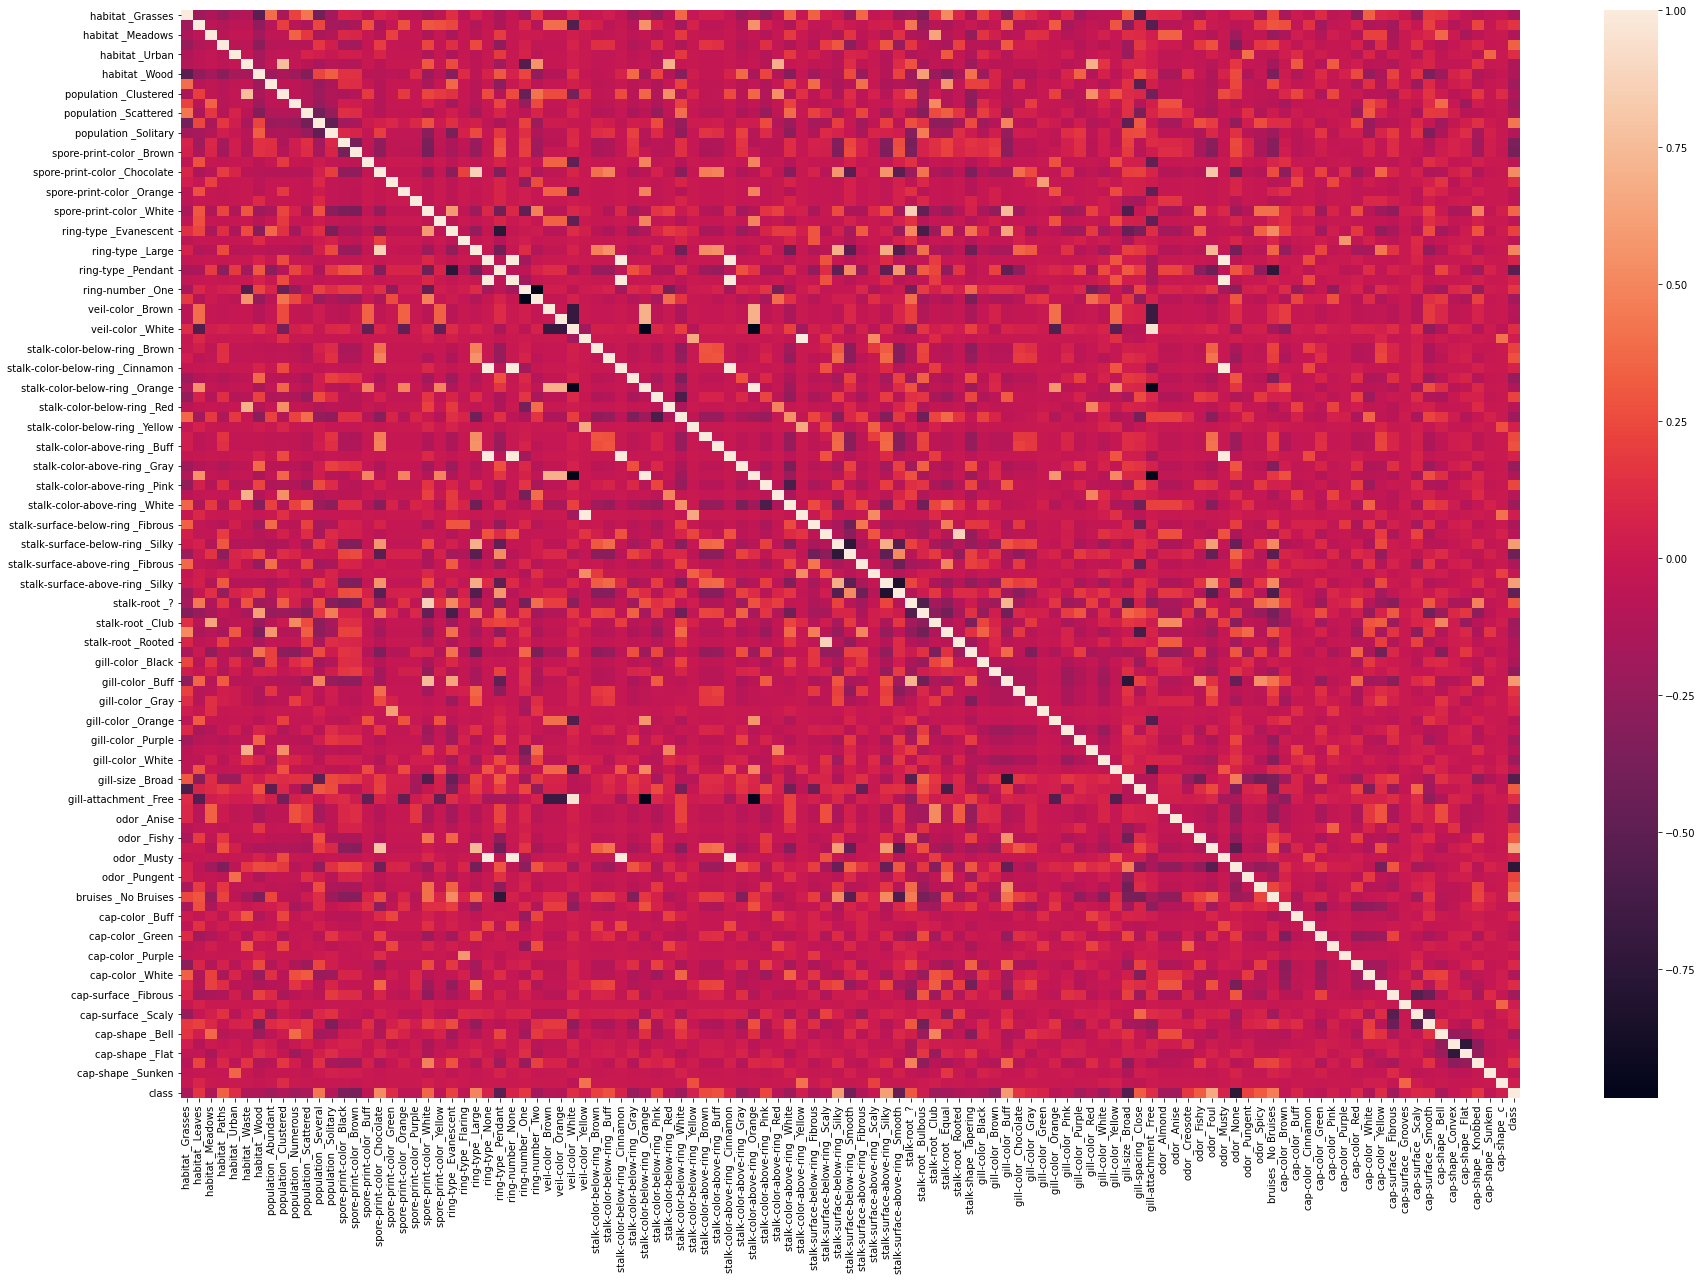

In [23]:
plt.figure(figsize=(30,20))
sns.heatmap(data_prep4.drop('id',axis=1).corr())

In [24]:
data_prep4.shape

(6571, 112)

In [25]:
train_new_data=data_prep4.iloc[0:4599,0:]
test_new_data=data_prep4.iloc[4599:,0:]
train_new_data.tail()

,habitat _Grasses,habitat _Leaves,habitat _Meadows,habitat _Paths,habitat _Urban,habitat _Waste,habitat _Wood,population _Abundant,population _Clustered,population _Numerous,population _Scattered,population _Several,population _Solitary,spore-print-color _Black,spore-print-color _Brown,spore-print-color _Buff,spore-print-color _Chocolate,spore-print-color _Green,spore-print-color _Orange,spore-print-color _Purple,spore-print-color _White,spore-print-color _Yellow,ring-type _Evanescent,ring-type _Flaring,ring-type _Large,ring-type _None,ring-type _Pendant,ring-number _None,ring-number _One,ring-number _Two,veil-color _Brown,veil-color _Orange,veil-color _White,veil-color _Yellow,stalk-color-below-ring _Brown,stalk-color-below-ring _Buff,stalk-color-below-ring _Cinnamon,stalk-color-below-ring _Gray,stalk-color-below-ring _Orange,stalk-color-below-ring _Pink,stalk-color-below-ring _Red,stalk-color-below-ring _White,stalk-color-below-ring _Yellow,stalk-color-above-ring _Brown,stalk-color-above-ring _Buff,stalk-color-above-ring _Cinnamon,stalk-color-above-ring _Gray,stalk-color-above-ring _Orange,stalk-color-above-ring _Pink,stalk-color-above-ring _Red,stalk-color-above-ring _White,stalk-color-above-ring _Yellow,stalk-surface-below-ring _Fibrous,stalk-surface-below-ring _Scaly,stalk-surface-below-ring _Silky,stalk-surface-below-ring _Smooth,stalk-surface-above-ring _Fibrous,stalk-surface-above-ring _Scaly,stalk-surface-above-ring _Silky,stalk-surface-above-ring _Smooth,stalk-root _?,stalk-root _Bulbous,stalk-root _Club,stalk-root _Equal,stalk-root _Rooted,stalk-shape _Tapering,gill-color _Black,gill-color _Brown,gill-color _Buff,gill-color _Chocolate,gill-color _Gray,gill-color _Green,gill-color _Orange,gill-color _Pink,gill-color _Purple,gill-color _Red,gill-color _White,gill-color _Yellow,gill-size _Broad,gill-spacing _Close,gill-attachment _Free,odor _Almond,odor _Anise,odor _Creosote,odor _Fishy,odor _Foul,odor _Musty,odor _None,odor _Pungent,odor _Spicy,bruises _No Bruises,cap-color _Brown,cap-color _Buff,cap-color _Cinnamon,cap-color _Green,cap-color _Pink,cap-color _Purple,cap-color _Red,cap-color _White,cap-color _Yellow,cap-surface _Fibrous,cap-surface _Grooves,cap-surface _Scaly,cap-surface _Smooth,cap-shape _Bell,cap-shape _Convex,cap-shape _Flat,cap-shape _Knobbed,cap-shape _Sunken,cap-shape _c,id,class
4594,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,3032,0.0
4595,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,4250,1.0
4596,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1352,0.0
4597,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,724,1.0
4598,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1371,0.0


In [26]:
train_new_data_x=train_new_data.drop(['class','id'],axis=1)
train_new_data_y=train_new_data['class']

In [27]:
best_features = SelectKBest(chi2, k=2).fit(train_new_data_x, train_new_data_y)
best_features.scores_
dfscores = pd.DataFrame(best_features.scores_)
dfcolumns = pd.DataFrame(train_new_data_x.columns)
imp_cols=pd.concat([dfscores,dfcolumns],axis=1)
imp_cols.columns = ['Score','Specs'] 
imp_cols.nlargest(100,'Score')

,Score,Specs
85,1614.963280,odor _Foul
58,1326.655517,stalk-surface-above-ring _Silky
68,1321.003672,gill-color _Buff
54,1292.327446,stalk-surface-below-ring _Silky
87,1207.034041,odor _None
...,...,...
93,8.271524,cap-color _Cinnamon
95,6.104334,cap-color _Pink
33,5.443696,veil-color _Yellow
51,5.443696,stalk-color-above-ring _Yellow


In [28]:
X_train, X_test, y_train, y_test =train_test_split(train_new_data_x,train_new_data_y,train_size=0.7, shuffle=True)

In [29]:
X_train.shape

(3219, 110)

In [30]:
dtc=DecisionTreeClassifier()
dtc.fit(X_train, y_train)
dtcp=dtc.predict(X_test)
print(accuracy_score(dtcp,y_test))

cb=CatBoostClassifier(verbose=0)
cb.fit(X_train, y_train)
m=cb.predict(X_test)
print(accuracy_score(m,y_test))

lg=LGBMClassifier()
lg.fit(X_train, y_train)
ll=lg.predict(X_test)
print(accuracy_score(ll,y_test))

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_train,y_train)
ds=clf.predict(X_test)
print(accuracy_score(ds,y_test))


0.9992753623188406
0.9992753623188406
1.0
1.0


In [31]:
test_new_data_x=test_new_data.drop(['class','id'],axis=1)

In [32]:
dsa=clf.predict(test_new_data_x)
len(dsa)

1972

In [33]:
temp_sub.head()

,id,class
0,6545,Edibla
1,6495,Poisonousa
2,1634,Poisonousa
3,6164,Poisonousa
4,1858,Edibla


In [34]:
temp_sub['class']=dsa
temp_sub['class'] = np.where(temp_sub['class']==0,  'Edible','Poisonous')

In [35]:
temp_sub

,id,class
0,6545,Poisonous
1,6495,Edible
2,1634,Edible
3,6164,Edible
4,1858,Edible
...,...,...
1967,3899,Poisonous
1968,2265,Edible
1969,3918,Poisonous
1970,5202,Poisonous


In [36]:
temp_sub.to_csv("submission_be.csv",index=False)
print('Submission file shape is', temp_sub.shape )

Submission file shape is (1972, 2)
